## 0. Set up

In [567]:
import warnings
warnings.filterwarnings('ignore')

In [568]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime

## 1. Funções

In [569]:
def groupby_location(dataframe, country, date_column, location_column, 
    list_of_cases_columns, location = None
    ):
    
    list_of_columns = [date_column, location_column]
    for column in list_of_cases_columns:
        list_of_columns.append(column)
    dict_of_columns = {}
    for column in list_of_cases_columns:
        dict_of_columns[column] = "sum"
    
    if location is None:     
        dataframe = dataframe[list_of_columns]
        dataframe = (dataframe
                         .groupby([date_column])
                         .agg(dict_of_columns)
                         .reset_index())
        dataframe["location"] = country
        dataframe = dataframe.sort_values(by=date_column)
    else:
        dataframe = dataframe[dataframe[location_column] == location]
        dataframe = dataframe[list_of_columns]
        dataframe = (dataframe
                         .groupby([date_column])
                         .agg(dict_of_columns)
                         .reset_index())
        dataframe["location"] = location
        dataframe = dataframe.sort_values(by=date_column)
        
    return dataframe

def groupby_location_all_locations(dataframe, date_column, city_column,
    state_column, list_of_cases_columns
    ):
    
    list_of_columns = [date_column, city_column, state_column]
    for column in list_of_cases_columns:
        list_of_columns.append(column)
    dict_of_columns = {}
    for column in list_of_cases_columns:
        dict_of_columns[column] = "max"
        
    dataframe = dataframe[list_of_columns]
    dataframe = (dataframe
                     .groupby([date_column, city_column, state_column])
                     .agg(dict_of_columns)
                     .reset_index())
    dataframe = dataframe.sort_values(by=[state_column, city_column, date_column])

    return dataframe

def correcting_types(dataframe, date_column, date_format, list_of_cases_columns):
    dataframe[date_column] = (dataframe[date_column]
                             .apply(lambda x: datetime.strptime(x, date_format)))
    
    for column in list_of_cases_columns:
        dataframe[column] = dataframe[column].astype(float)
        
    return dataframe    

def create_date_table(start, end):
    dataframe = pd.DataFrame({"date": pd.date_range(start, end)})
    
    return dataframe

def get_date_index(dataframe, date_column, cases_column, max_date):
    calendar = create_date_table(min(dataframe[dataframe[cases_column]>=1][date_column]), max_date)
    calendar = calendar.reset_index()
    calendar.rename(columns={'index':'date_index'}, inplace=True)
    calendar['date_index'] = calendar['date_index'] + 1
    
    return calendar

def date_linear_coef(dataframe, date_column, cases_column, max_date, index):
    calendar = get_date_index(dataframe, date_column, cases_column, max_date)
    dataframe = dataframe[dataframe[cases_column]>=1]
    dataframe = dataframe.merge(calendar, how = "left", on=date_column)
    a, b = np.polyfit(dataframe[index], np.log(dataframe[cases_column]), 1)
    
    return a, b

def date_linear_predict(dataframe, date_column, cases_column, location_column, max_date, index):
    a,b = date_linear_coef(dataframe, date_column, cases_column, max_date, index)
    predictions = get_date_index(dataframe, date_column, cases_column, max_date)
    predictions['date_predict'] = predictions[index].apply(lambda x: float(a)*float(x) + float(b))
    predictions['location'] = dataframe[location_column].max()
    
    return predictions

def get_list_of_cities_and_states(dataframe, city_column, state_column, cases_columns):
    dataframe = (dataframe
                     .groupby([city_column, state_column])
                     .agg({cases_columns: 'sum'})
                     .reset_index()
                     .drop(columns=[cases_columns])
                )
    
    return dataframe

def cross_join_calendar(dataframe, calendar_df):
    dataframe['key'] = 1
    calendar_df['key'] = 1
    
    cross_join_df = pd.merge(dataframe, calendar_df, on = 'key')
    cross_join_df = cross_join_df.drop(columns = ['key'])
    
    return cross_join_df

def interpolate_in_partitions(dataframe, city_column, cases_column, output_col):
    list_of_columns = dataframe.columns
    df = pd.DataFrame(columns = dataframe.columns)
    
    for city in dataframe[city_column].unique():
        temp_dataframe = dataframe[dataframe[city_column] == city]
        temp_dataframe[output_col] = temp_dataframe[cases_column].interpolate(method="linear")
        df = pd.concat([df, temp_dataframe],  ignore_index=True)
    
    df[output_col] = np.floor(df[output_col])
    df[output_col] = df[output_col].fillna(0)
    
    return df

## 2. Bases de dados

In [570]:
covid19_br_kaggle = pd.read_csv("../data/coronavirus_brazil_kaggle/brazil_covid19.csv")
covid19_br_vicosa_cites = pd.read_csv("../data/coronavirus_brazil_vicosa/cases-brazil-cities.csv")
covid19_br_vicosa_cites_times = pd.read_csv("../data/coronavirus_brazil_vicosa/cases-brazil-cities-time.csv")
covid19_br_vicosa_states = pd.read_csv("../data/coronavirus_brazil_vicosa/cases-brazil-states.csv")
covid19_br_vicosa_brazil = pd.read_csv("../data/coronavirus_brazil_vicosa/cases-brazil-total.csv")
gov_br_novocoronavirus = pd.read_csv("../data/coronavirus_brazil_vicosa/plataforma-saude-gov-br-novocoronavirus.csv")
covid19_br_nagano = pd.read_csv("../data/coronavirus_nagano/base_diária_por_municipio.csv")
covid19_br_brasilio = pd.read_csv("../data/brasilio/base_diaria_por_municipio.csv")

#### 1.1 Exploração de dados premliminar

##### kaggle_brazil

In [571]:
covid19_br_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      981 non-null    object
 1   hour      684 non-null    object
 2   state     981 non-null    object
 3   suspects  981 non-null    int64 
 4   refuses   981 non-null    int64 
 5   cases     981 non-null    int64 
 6   deaths    981 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 53.8+ KB


In [572]:
covid19_br_kaggle.head()

,date,hour,state,suspects,refuses,cases,deaths
0,2020-01-30,16:00,Minas Gerais,1,0,0,0
1,2020-01-30,16:00,Rio de Janeiro,1,0,0,0
2,2020-01-30,16:00,Santa Catarina,0,2,0,0
3,2020-01-30,16:00,São Paulo,3,1,0,0
4,2020-01-30,16:00,Rio Grande do Sul,2,2,0,0


In [573]:
columns_list = ["suspects", "refuses", "cases", "deaths"]
covid19_br_kaggle_brasil = groupby_location(covid19_br_kaggle, "Brasil", "date", "state", columns_list)
covid19_br_kaggle_sp = groupby_location(covid19_br_kaggle, "Brasil", "date", "state", columns_list, location = "São Paulo")

covid19_br_kaggle_brasil = correcting_types(covid19_br_kaggle_brasil, "date", '%Y-%m-%d', columns_list)
covid19_br_kaggle_sp = correcting_types(covid19_br_kaggle_sp, "date", '%Y-%m-%d', columns_list)

In [574]:
print("Faixa de data:\nData mínima: {0}\nData máxima: {1}".format(min(covid19_br_kaggle['date']), max(covid19_br_kaggle['date'])))
print("\nNúmero de casos confirmados até data máxima:\nBrasil: {0}\nSão Paulo: {1}".format(covid19_br_kaggle_brasil['cases'].tail(1).sum(), covid19_br_kaggle_sp['cases'].tail(1).sum()))

Faixa de data:
Data mínima: 2020-01-30
Data máxima: 2020-03-29

Número de casos confirmados até data máxima:
Brasil: 4266.0
São Paulo: 1451.0


In [575]:
covid19_brasil = pd.concat([covid19_br_kagle_brasil, covid19_br_kagle_sp], ignore_index=True)

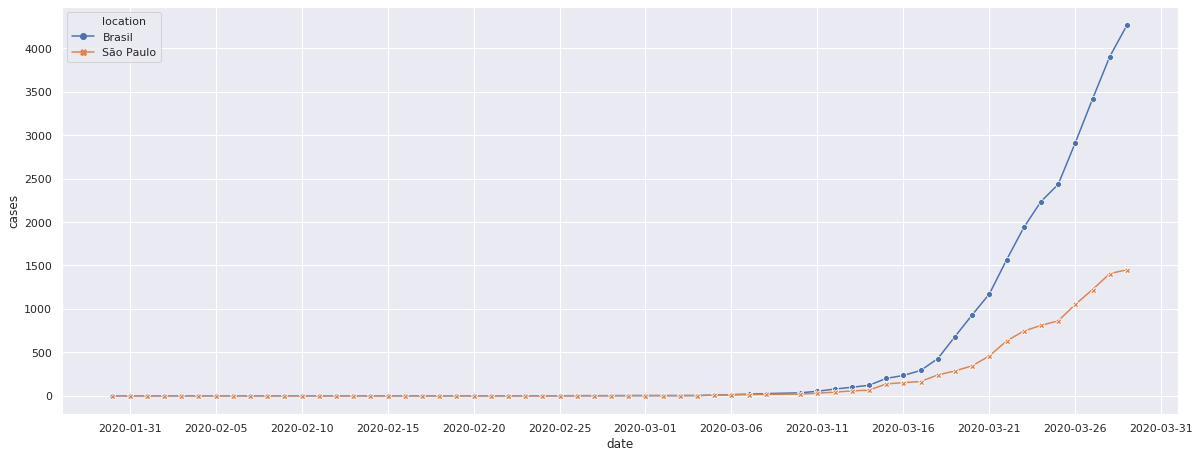

In [576]:
plt.figure(figsize=(20,7.5))
ax = sns.lineplot(x="date", y="cases",
                  hue="location", markers=True, style = "location",
                  dashes=False, data=covid19_brasil)

ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

##### universidade_de_vicosa

In [577]:
covid19_br_vicosa_cites_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        2040 non-null   object
 1   country     2040 non-null   object
 2   state       2040 non-null   object
 3   city        2040 non-null   object
 4   ibgeID      2040 non-null   int64 
 5   newCases    2040 non-null   int64 
 6   totalCases  2040 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 111.7+ KB


In [578]:
covid19_br_vicosa_cites_times.head(5)

,date,country,state,city,ibgeID,newCases,totalCases
0,2020-02-25,Brazil,SP,São Paulo/SP,3550308,1,1
1,2020-02-25,Brazil,TOTAL,TOTAL,3550308,1,1
2,2020-02-29,Brazil,SP,São Paulo/SP,3550308,1,2
3,2020-02-29,Brazil,TOTAL,TOTAL,3550308,1,2
4,2020-03-04,Brazil,SP,São Paulo/SP,3550308,1,3


In [579]:
columns_list = ["newCases", "totalCases"]
covid19_br_vicosa_sp = groupby_location(covid19_br_vicosa_cites_times, "Brasil", "date", "city", columns_list, location = "São Paulo/SP")
covid19_br_vicosa_sp = correcting_types(covid19_br_vicosa_sp, "date", '%Y-%m-%d', columns_list)

In [580]:
print("Faixa de data:\nData mínima: {0}\nData máxima: {1}".format(min(covid19_br_vicosa_cites_times['date']), max(covid19_br_vicosa_cites_times['date'])))
print("\nNúmero de casos confirmados até data máxima:\nSão Paulo: {0}".format(covid19_br_vicosa_sp['totalCases'].tail(1).sum()))

Faixa de data:
Data mínima: 2020-02-25
Data máxima: 2020-03-27

Número de casos confirmados até data máxima:
São Paulo: 1044.0


In [581]:
## join
covid19_br_vicosa_sp['cases'] = covid19_br_vicosa_sp['totalCases']
covid19_br_vicosa_sp = covid19_br_vicosa_sp[['date','location','cases']]
covid19_brasil = covid19_brasil[['date','location','cases']]
covid19_brasil = pd.concat([covid19_brasil, covid19_br_vicosa_sp], ignore_index=True)

#### bases nagano

In [582]:
covid19_br_nagano.head()

,data,municipio,uf,casos confirmados,mortes,fonte,última atualização,validação,flag_cosistencia,flag_cosistencia_num
0,29/03/2020,Acrelândia,AC,2,NaN,https://g1.globo.com/ac/acre/noticia/2020/03/2...,Desconhecida,-999,Consistente,0
1,29/03/2020,Porto Acre,AC,1,NaN,https://g1.globo.com/ac/acre/noticia/2020/03/2...,Desconhecida,-999,Consistente,0
2,17/03/2020,Rio Branco,AC,3,NaN,https://g1.globo.com/ac/acre/noticia/2020/03/1...,Desconhecida,-999,Consistente,0
3,18/03/2020,Rio Branco,AC,3,NaN,NaN,Desconhecida,0,Consistente,0
4,19/03/2020,Rio Branco,AC,4,NaN,NaN,Desconhecida,1,Consistente,0


In [583]:
columns_list = ["casos confirmados"]
covid19_br_nagano_sp = groupby_location(covid19_br_nagano, "Brasil", "data", "municipio", columns_list, location = "São Paulo")
covid19_br_nagano_sp = correcting_types(covid19_br_nagano_sp, "data", '%d/%m/%Y', columns_list)
covid19_br_nagano_sp['location'] = "São Paulo/SP - Nagano"
covid19_br_nagano_sp.rename(columns={'data':'date', 'casos confirmados':'cases'}, inplace=True)

In [584]:
print("Faixa de data:\nData mínima: {0}\nData máxima: {1}".format(min(covid19_br_nagano_sp['date']), max(covid19_br_nagano_sp['date'])))
print("\nNúmero de casos confirmados até data máxima:\nBrasil: {0}\nSão Paulo: {1}".format(covid19_br_nagano_sp['cases'].tail(1).sum(), covid19_br_nagano_sp['cases'].tail(1).sum()))

Faixa de data:
Data mínima: 2020-02-26 00:00:00
Data máxima: 2020-03-30 00:00:00

Número de casos confirmados até data máxima:
Brasil: 1233.0
São Paulo: 1233.0


In [585]:
covid19_brasil = pd.concat([covid19_brasil, covid19_br_nagano_sp], ignore_index=True)

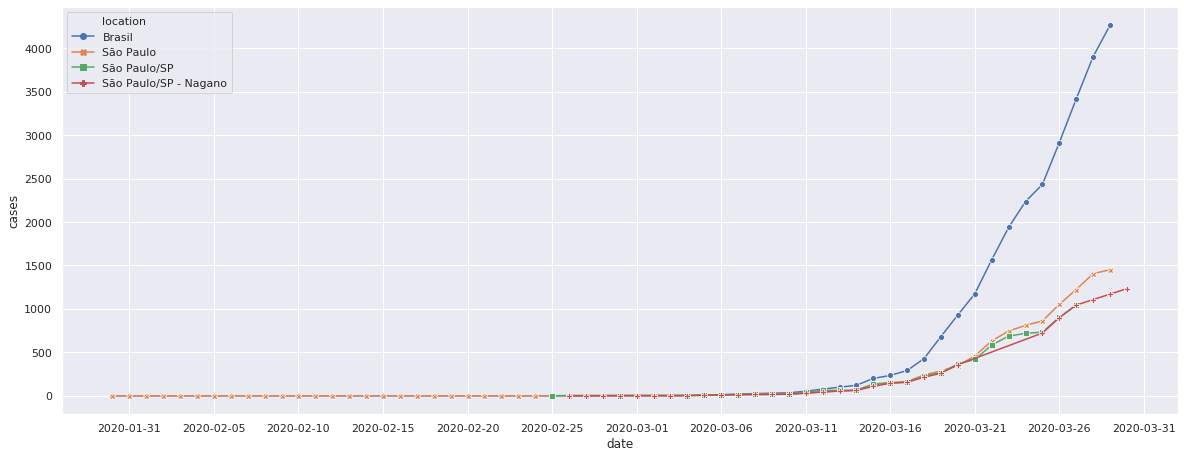

In [586]:
plt.figure(figsize=(20,7.5))
ax = sns.lineplot(x="date", y="cases",
                  hue="location", markers=True, style = "location",
                  dashes=False, data=covid19_brasil)

ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

## base brasilio

In [587]:
covid19_br_brasilio = covid19_br_brasilio.dropna(subset=['city'])

In [588]:
columns_list = ["confirmed","deaths"]
covid19_br_brasilio = groupby_location(covid19_br_brasilio, "Brasil", "date", "city", columns_list, location = "São Paulo")
covid19_br_brasilio = correcting_types(covid19_br_brasilio, "date", '%Y-%m-%d', columns_list)
covid19_br_brasilio['location'] = "São Paulo/SP - Brasilio"
covid19_br_brasilio.rename(columns={'confirmed':'cases'}, inplace=True)

In [589]:
print("Faixa de data:\nData mínima: {0}\nData máxima: {1}".format(min(covid19_br_brasilio['date']), max(covid19_br_brasilio['date'])))
print("\nNúmero de casos confirmados até data máxima:\nSão Paulo: {0}".format(covid19_br_brasilio['cases'].tail(1).sum()))

Faixa de data:
Data mínima: 2020-02-26 00:00:00
Data máxima: 2020-03-30 00:00:00

Número de casos confirmados até data máxima:
São Paulo: 1233.0


In [590]:
compare_sp = pd.concat([covid19_br_brasilio, covid19_br_nagano_sp], ignore_index=True)

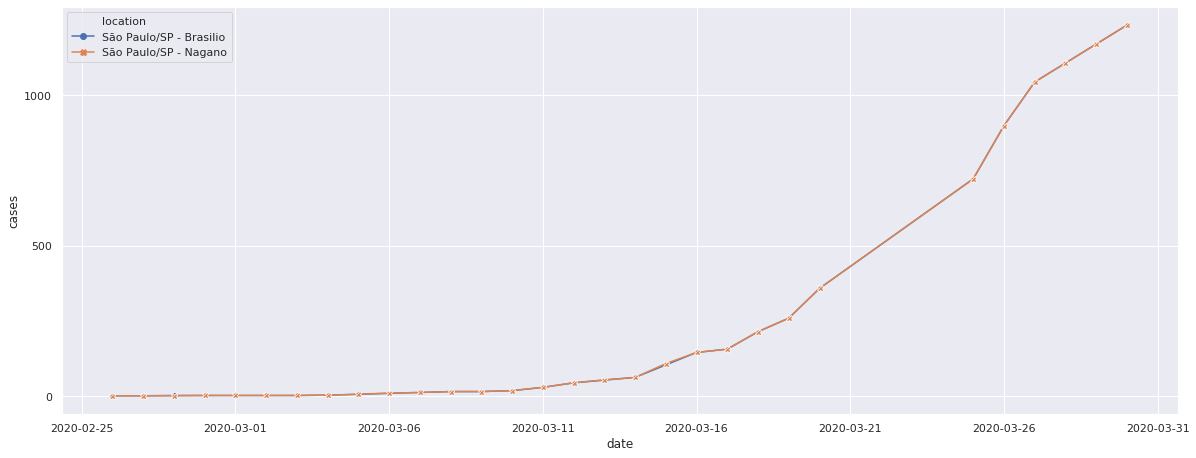

In [591]:
plt.figure(figsize=(20,7.5))
ax = sns.lineplot(x="date", y="cases",
                  hue="location", markers=True, style = "location",
                  dashes=False, data=compare_sp)

ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

## Completando os dados da base

In [592]:
calendar = create_date_table("2020-02-20", "2020-03-30")
covid19_br_nagano_cities = get_list_of_cities_and_states(covid19_br_nagano, 'municipio', 'uf', 'casos confirmados')
covid19_br_nagano_complete = cross_join_calendar(covid19_br_nagano_cities, calendar)

In [593]:
list_of_columns = ['casos confirmados', 'mortes']
covid19_br_nagano_grouped = groupby_location_all_locations(covid19_br_nagano,'data', 'municipio', 'uf', list_of_columns)
covid19_br_nagano_grouped = correcting_types(covid19_br_nagano_grouped, "data", '%d/%m/%Y', list_of_columns)
covid19_br_nagano_grouped.rename(columns={'data':'date'}, inplace=True)

In [594]:
covid19_br_nagano_complete = covid19_br_nagano_complete.merge(covid19_br_nagano_grouped, 
                                                              how='left',
                                                              on=['date','municipio','uf'])
covid19_br_nagano_complete = interpolate_in_partitions(covid19_br_nagano_complete,
                                                       'municipio',
                                                       'casos confirmados',
                                                       'casss_interpolados')
covid19_br_nagano_complete = interpolate_in_partitions(covid19_br_nagano_complete,
                                                       'municipio',
                                                       'mortes',
                                                       'mortes_interpoladas')

In [595]:
covid19_br_nagano_complete.to_csv('base_diaria_por_municipio.csv', header=True, sep=";")

## Ajuste log-linear

In [596]:
covid19_brasil["log_cases"] = np.log(covid19_brasil["cases"])

In [597]:
sp_city_df = covid19_brasil[covid19_brasil['location'] == 'São Paulo/SP']
sp_city_nangano = covid19_brasil[covid19_brasil['location'] == 'São Paulo/SP - Nagano']
sp_state_df = covid19_brasil[covid19_brasil['location'] == 'São Paulo']
brasil_df = covid19_brasil[covid19_brasil['location'] == 'Brasil']

(737480.0, 737516.0)

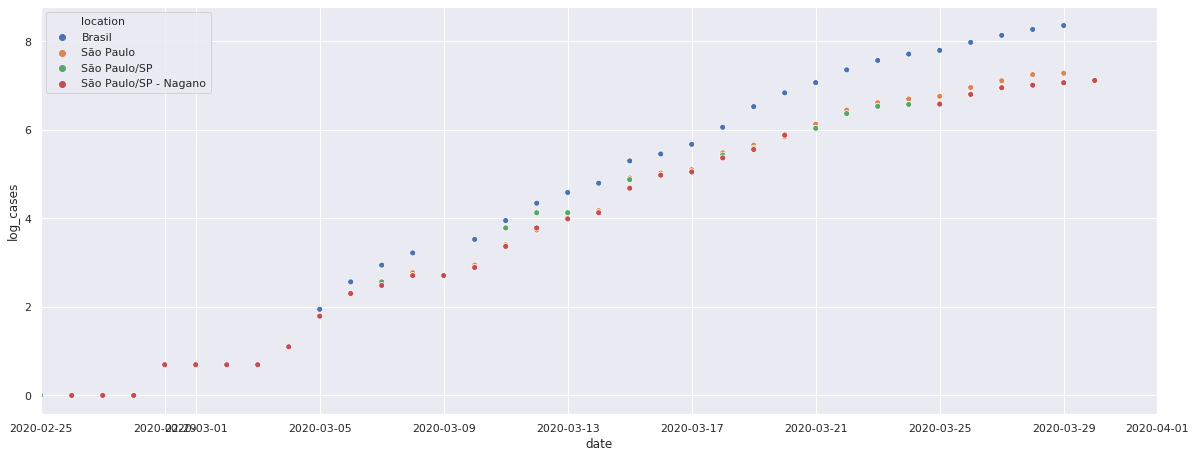

In [598]:
plt.figure(figsize=(20,7.5))
ax = sns.scatterplot(x="date", y="log_cases",
                     hue="location", markers=True, data=covid19_brasil)


# control x and y limits
ax.set_xlim(min(covid19_brasil[covid19_brasil["cases"]>=1]['date']),datetime.strptime("2020-04-01", '%Y-%m-%d'))

In [78]:
sp_city_predictions = date_linear_predict(sp_city_df, "date", "cases", "location", "2020-04-05", "date_index")
sp_state_df_predictions = date_linear_predict(sp_state_df, "date", "cases", "location", "2020-04-05", "date_index")
brasil_df_predictions = date_linear_predict(brasil_df, "date", "cases", "location", "2020-04-05", "date_index")
sp_city_nangano_predictions = date_linear_predict(sp_city_nangano, "date", "cases", "location", "2020-04-05", "date_index")

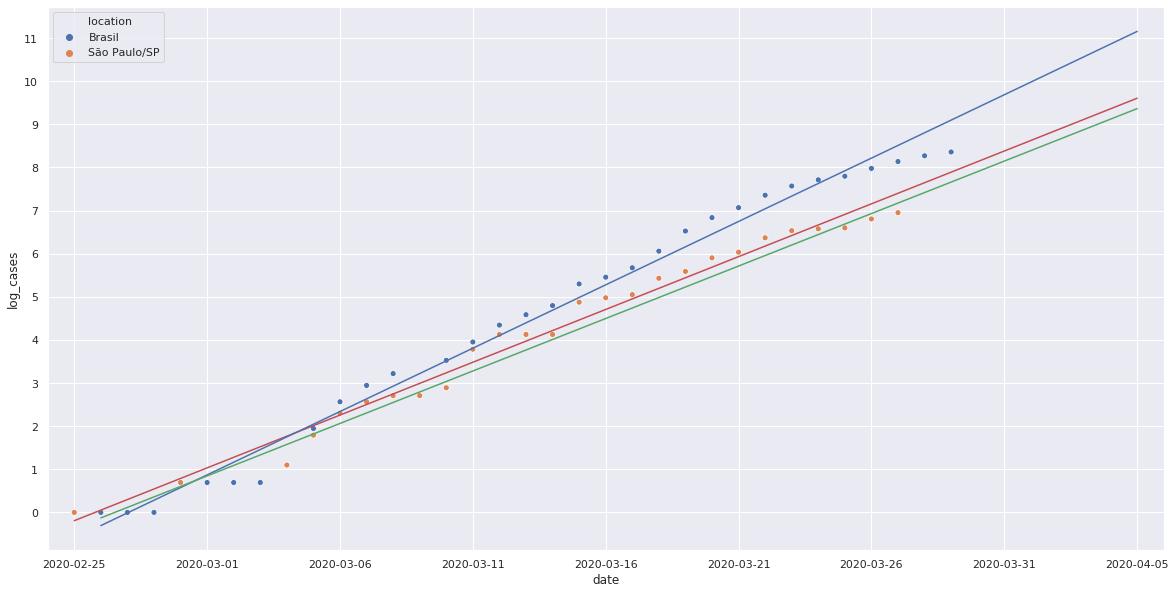

In [80]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="date", y="log_cases",
                     hue="location", markers=True, data=covid19_brasil[covid19_brasil['location'].isin(["Brasil","São Paulo/SP"])])

# control x and y limits
ax.set_xlim(datetime.strptime("2020-02-24", '%Y-%m-%d'),datetime.strptime("2020-04-06", '%Y-%m-%d'))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

plt.plot(sp_city_predictions['date'], sp_city_predictions['date_predict'], color='r')
plt.plot(brasil_df_predictions['date'], brasil_df_predictions['date_predict'], color='b')
plt.plot(sp_city_nangano_predictions['date'], sp_city_nangano_predictions['date_predict'], color='g')
plt.show()